# Web Scraping

In [ ]:
!pip install webdriver_manager --upgrade 
# update webdriver_manager if error is shown with the code :  "driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))"

In [13]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import ActionChains
from bs4 import BeautifulSoup
import time
import re
from pandas import Series,DataFrame
import pandas as pd

url ='https://millercenter.org/the-presidency/presidential-speeches'
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get(url)
driver.implicitly_wait(2)
driver.maximize_window()

for i in range(1,50):
    driver.find_element(By.TAG_NAME,'body').send_keys(Keys.END)
    time.sleep(2)

html = driver.page_source
soup = BeautifulSoup(html,'html.parser')
div = soup.select('div.views-row')

url_lst = []
for i in div:
    url_lst.append(i.select_one('div.views-field.views-field-title > span.field-content > a')['href'])
url_lst

['https://millercenter.org/the-presidency/presidential-speeches/february-21-2023-remarks-one-year-anniversary-ukraine-war',
 'https://millercenter.org/the-presidency/presidential-speeches/february-7-2023-state-union-address',
 'https://millercenter.org/the-presidency/presidential-speeches/september-21-2022-speech-77th-session-united-nations-general',
 'https://millercenter.org/the-presidency/presidential-speeches/september-1-2022-remarks-continued-battle-soul-nation',
 'https://millercenter.org/the-presidency/presidential-speeches/may-24-2022-remarks-school-shooting-uvalde-texas',
 'https://millercenter.org/the-presidency/presidential-speeches/march-26-2022-remarks-support-people-ukraine',
 'https://millercenter.org/the-presidency/presidential-speeches/march-1-2022-state-union-address',
 'https://millercenter.org/the-presidency/presidential-speeches/february-24-2022-remarks-russian-invasion-ukraine',
 'https://millercenter.org/the-presidency/presidential-speeches/january-6-2022-remarks

Pickling the URL list of U.S. president speeches 

In [15]:
import pickle

file = open("c:/data/url.txt","wb")
pickle.dump(url_lst, file)
file.close()

UnPickling the URL list of U.S. president speeches

In [16]:
import pickle

file = open("c:/data/url.txt","rb")
url_lst = pickle.load(file)
file.close()

<br>

# Creating a DataFrame of the Speeches from URL list

In [17]:
len(url_lst)

1045

In [20]:

df = DataFrame()

for i in url_lst:
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(i)
    driver.implicitly_wait(2)
    driver.maximize_window()

    html = driver.page_source
    driver.quit()
    soup = BeautifulSoup(html,'html.parser')
    name = soup.select_one('p.president-name').text
    date = soup.select_one('p.episode-date').text
    title = soup.select_one('h2.presidential-speeches--title').text
    transcript = soup.select_one('div.view-transcript').text
    temp = DataFrame({'name':name, 'date':date, 'title':title, 'transcript': transcript},index=[0])

    df = pd.concat([df,temp],ignore_index=True)
    time.sleep(2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        1045 non-null   object
 1   date        1045 non-null   object
 2   title       1045 non-null   object
 3   transcript  1045 non-null   object
dtypes: object(4)
memory usage: 32.8+ KB


Saving the DataFrame as csv

In [21]:
df.to_csv('c:/data/us_president_speech.csv',index=False)

Loding the DataFrame csv

In [1]:
import pandas as pd

df = pd.read_csv('c:/data/us_president_speech.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        1045 non-null   object
 1   date        1045 non-null   object
 2   title       1045 non-null   object
 3   transcript  1045 non-null   object
dtypes: object(4)
memory usage: 32.8+ KB


<br>

# Preprocessing

## Text Preprocessing: Removing Metadata and Standardizing Format

In [3]:
replacement_patterns = [
    ('View Transcript', ' ', False),
    ('Transcript', ' ', False),
    ('\n', ' ', True),
    ('\xa0', ' ', True),
    ('By the President of the United States of America', ' ', False),
    ('Proclamation', ' ', False),
    ('THE PRESIDENT:', ' ', False),
    ('President Clinton:', ' ', False),
    ('Audience: No-o-o!', ' ', False),
    ('PRESIDENT TRUMP', ' ', False),
    ('THE PRESIDENT.', ' ', True),
    ('THE PRESIDENT said:', ' ', False),
    ('President Bush.', ' ', True),
    ('Audience members. Boo-o-o!', ' ', True),
    ('Audience members. Viva Bush! Viva Bush! Viva Bush!', ' ', True),
    ('Audience members. U.S.A.! U.S.A.! U.S.A.!', ' ', True),
    ('AUDIENCE: H.R.3! H.R.3! H.R.3!', ' ', True),
    ('THE PRESIDENT made the following statement:', ' ', False),
    ('IN REPLY to press questions as to the business situation the President said:', ' ', False),
    ('\[applause\]', '', True),
    ('\[Laughter\]', '', True),
    ('\[Applause\]', '', True),
    ('\(Applause.\)', '', True),
    ('\(Laughter.\)', '', True),
    ('\(Audience interruption.\)', '', True),
    ('\(APPLAUSE\)', '', True),
    ('\(applause\)', '', True),
    ('’', '\'', True),
    ('  ', ' ', True)
]

for pattern, replacement, is_regex in replacement_patterns:
    df['transcript'] = df['transcript'].str.replace(pattern, replacement, regex=is_regex)

df['transcript'] = df['transcript'].str.strip()
df['transcript'] = df['transcript'].str.lower()

<br>

## Labeling Presidential Party Affiliation

In [4]:
df['party'] = None

df.loc[df['name'] == 'Lyndon B. Johnson','party'] = 'Democrat'
df.loc[df['name'] == 'Ronald Reagan','party'] = 'Republican'
df.loc[df['name'] == 'Barack Obama','party'] = 'Democrat'
df.loc[df['name'] == 'Franklin D. Roosevelt','party'] = 'Democrat'
df.loc[df['name'] == 'John F. Kennedy','party'] = 'Democrat'
df.loc[df['name'] == 'Donald Trump','party'] = 'Republican'
df.loc[df['name'] == 'George W. Bush','party'] = 'Republican'
df.loc[df['name'] == 'Bill Clinton','party'] = 'Democrat'
df.loc[df['name'] == 'Woodrow Wilson','party'] = 'Democrat'
df.loc[df['name'] == 'Ulysses S. Grant','party'] = 'Republican'
df.loc[df['name'] == 'Andrew Johnson','party'] = 'National Union'
df.loc[df['name'] == 'Herbert Hoover','party'] = 'Republican'
df.loc[df['name'] == 'Grover Cleveland','party'] = 'Democrat'
df.loc[df['name'] == 'Andrew Jackson','party'] = 'Democrat'
df.loc[df['name'] == 'James K. Polk','party'] = 'Democrat'
df.loc[df['name'] == 'Thomas Jefferson','party'] = 'Democratic-Republican'
df.loc[df['name'] == 'Richard M. Nixon','party'] = 'Republican'
df.loc[df['name'] == 'George H. W. Bush','party'] = 'Republican'
df.loc[df['name'] == 'Benjamin Harrison','party'] = 'Republican'
df.loc[df['name'] == 'James Madison','party'] = 'Democratic-Republican'
df.loc[df['name'] == 'Jimmy Carter','party'] = 'Democrat'
df.loc[df['name'] == 'Theodore Roosevelt','party'] = 'Republican'
df.loc[df['name'] == 'George Washington','party'] = None
df.loc[df['name'] == 'Joe Biden','party'] = 'Democrat'
df.loc[df['name'] == 'Harry S. Truman','party'] = 'Democrat'
df.loc[df['name'] == 'Warren G. Harding','party'] = 'Republican'
df.loc[df['name'] == 'John Tyler','party'] = 'Whig'
df.loc[df['name'] == 'Rutherford B. Hayes','party'] = 'Republican'
df.loc[df['name'] == 'Franklin Pierce','party'] = 'Democrat'
df.loc[df['name'] == 'Abraham Lincoln','party'] = 'Republican'
df.loc[df['name'] == 'Gerald Ford','party'] = 'Republican'
df.loc[df['name'] == 'William McKinley','party'] = 'Republican'
df.loc[df['name'] == 'James Buchanan','party'] = 'Democrat'
df.loc[df['name'] == 'William Taft','party'] = 'Republican'
df.loc[df['name'] == 'Calvin Coolidge','party'] = 'Republican'
df.loc[df['name'] == 'Chester A. Arthur','party'] = 'Republican'
df.loc[df['name'] == 'Martin Van Buren','party'] = 'Democrat'
df.loc[df['name'] == 'James Monroe','party'] = 'Democratic-Republican'
df.loc[df['name'] == 'John Adams','party'] = 'Federalist'
df.loc[df['name'] == 'John Quincy Adams','party'] = 'Democratic-Republican'
df.loc[df['name'] == 'Millard Fillmore','party'] = 'Whig'
df.loc[df['name'] == 'Dwight D. Eisenhower','party'] = 'Republican'
df.loc[df['name'] == 'Zachary Taylor','party'] = 'Whig'
df.loc[df['name'] == 'William Harrison','party'] = 'Whig'
df.loc[df['name'] == 'James A. Garfield','party'] = 'Republican'

<br>

# Naive Bayes

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

df_party = df[(df['party'] == 'Democrat') | (df['party'] == 'Republican')]

x_train, x_test, y_train, y_test = train_test_split(df_party['transcript'],
                                                    df_party['party'],test_size=0.2,
                                                    random_state=1234,stratify = df_party['party']) 

stopwords = stopwords.words('english')

vect = CountVectorizer(stop_words=stopwords,ngram_range=(1,3))
vect.fit(x_train)
x_train = vect.transform(x_train)

    
# 테스트 데이터
x_test = vect.transform(x_test)

# 테스트 데이터 정답
y_test

nb = MultinomialNB()
nb.fit(x_train,y_train) # 학습을 수행

y_predict = nb.predict(x_test)

print("Accuracy Score : ", accuracy_score(y_test,y_predict)) 

Accuracy Score :  0.8820224719101124


In [7]:
pd.crosstab(y_test, y_predict)

col_0,Democrat,Republican
party,,
Democrat,84,9
Republican,12,73


In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

    Democrat       0.88      0.90      0.89        93
  Republican       0.89      0.86      0.87        85

    accuracy                           0.88       178
   macro avg       0.88      0.88      0.88       178
weighted avg       0.88      0.88      0.88       178



<br>

# Predict the political leanings of U.S. Presidents from other parties by classifying their speeches into Democrat or Republican

### Define Functions to predict the political leanings of the speeches and create pie chart

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series

def predict(arg):
    x_test = vect.transform(Series(arg))
    return nb.predict(x_test)[0]

def plot_party_distribution(df, vect, nb, president_name):
    
    """
    Plots a pie chart of party distribution for a given president's transcripts.
    Parameters:
    - df: DataFrame containing data.
    - vect: Vectorizer (Assuming it's pre-fitted).
    - nb: Model (Assuming it's pre-trained).
    - president_name: Name of the president to plot for.
    """
    
    # Get predictions for all transcripts of given president_name
    predictions = df[df['name'] == president_name]['transcript'].apply(predict)

    # Counting Democrat and Republican predictions
    dem_count = sum(predictions == 'Democrat')
    rep_count = sum(predictions == 'Republican')

    # Set figure size
    plt.rcParams['figure.figsize'] = [5,5]

    # Conditionally set ratios, labels, colors, and explode values
    if dem_count > 0 and rep_count > 0:
        ratios = [dem_count, rep_count]
        labels = ['Democrat', 'Republican']
        colors = ['royalblue','firebrick']
        explode = (0.1, 0.0)
    elif rep_count == 0:
        ratios = [dem_count]
        labels = ['Democrat']
        colors = ['royalblue']
        explode = (0.1,)
    elif dem_count == 0:
        ratios = [rep_count]
        labels = ['Republican']
        colors = ['firebrick']
        explode = (0.1,)

    plt.pie(ratios,
            labels=labels,
            autopct='%.0f%%',
            colors=colors,
            textprops={'fontsize': 15, 'weight': 'bold'},
            explode=explode,
            startangle=-140,
            wedgeprops={'width': 1, "linewidth": 2, "edgecolor": 'black'},
            shadow=True)

    plt.title(president_name, size=20, fontdict={'fontweight': 'bold'}, bbox={'facecolor': 'royalblue', 'pad': 5, 'alpha': 0.7}, loc='center')

<br>

### Andrew Johnson : National Union Party

In [69]:
df[df['name'] == 'Andrew Johnson']['transcript'].apply(predict) # National Union   

785    Republican
786      Democrat
787    Republican
788    Republican
789    Republican
790    Republican
791    Republican
792      Democrat
793    Republican
794    Republican
795    Republican
796    Republican
797      Democrat
798    Republican
799    Republican
800      Democrat
801    Republican
802    Republican
803    Republican
804    Republican
805    Republican
806    Republican
807      Democrat
808      Democrat
809    Republican
810    Republican
811    Republican
812    Republican
813    Republican
814    Republican
815      Democrat
Name: transcript, dtype: object

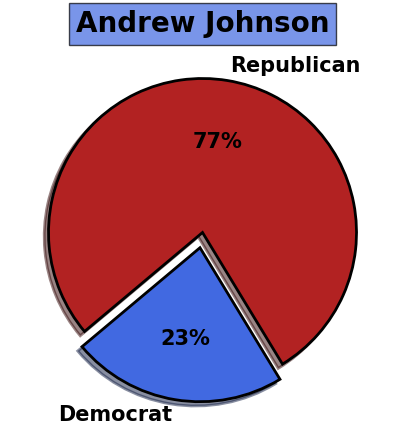

In [111]:
plot_party_distribution(df, vect, nb, 'Andrew Johnson')

<br>

### Millard Fillmore : Whig Party

In [54]:
df[df['name'] == 'Millard Fillmore']['transcript'].apply(predict) # Whig

859      Democrat
861    Republican
862    Republican
863      Democrat
864      Democrat
865      Democrat
866      Democrat
Name: transcript, dtype: object

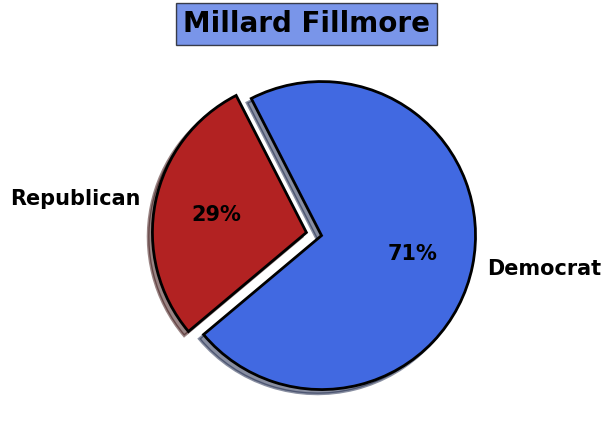

In [110]:
plot_party_distribution(df, vect, nb, 'Millard Fillmore')

<br>

### Zachary Taylor : Whig Party

In [55]:
df[df['name'] == 'Zachary Taylor']['transcript'].apply(predict) # Whig

867    Democrat
868    Democrat
869    Democrat
870    Democrat
Name: transcript, dtype: object

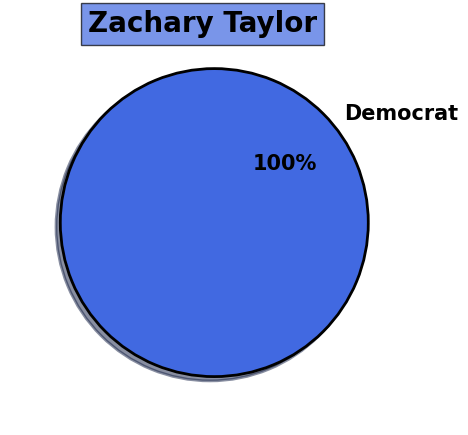

In [101]:
plot_party_distribution(df, vect, nb, 'Zachary Taylor')

<br>

### John Tyler : Whig Party

In [56]:
df[df['name'] == 'John Tyler']['transcript'].apply(predict) # Whig

896    Republican
897      Democrat
898      Democrat
899      Democrat
900      Democrat
901      Democrat
902    Republican
903      Democrat
904      Democrat
905    Republican
906      Democrat
907      Democrat
908      Democrat
909      Democrat
910      Democrat
911      Democrat
912      Democrat
913      Democrat
Name: transcript, dtype: object

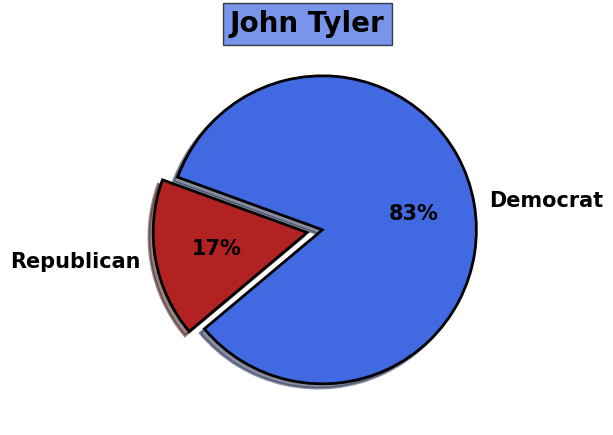

In [109]:
plot_party_distribution(df, vect, nb, 'John Tyler')

<br>

### William Harrison : Whig Party

In [95]:
df[df['name'] == 'William Harrison']['transcript'].apply(predict) # Whig

914    Democrat
Name: transcript, dtype: object

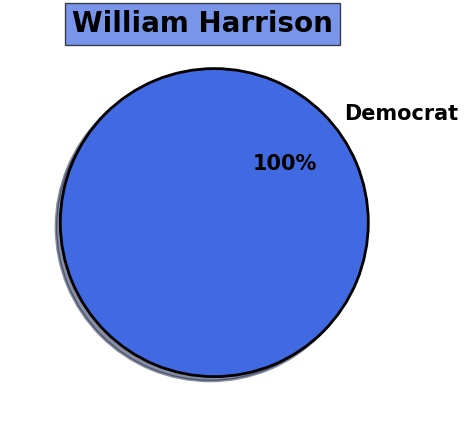

In [102]:
plot_party_distribution(df, vect, nb, 'William Harrison')

<br>

### John Quincy Adams : Democratic-Republican Party 

In [58]:
df[df['name'] == 'John Quincy Adams']['transcript'].apply(predict) # D-R

951    Democrat
952    Democrat
953    Democrat
954    Democrat
955    Democrat
956    Democrat
957    Democrat
962    Democrat
Name: transcript, dtype: object

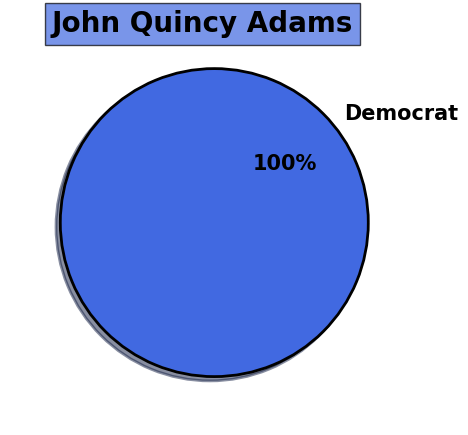

In [103]:
plot_party_distribution(df, vect, nb, 'John Quincy Adams')

<br>

### James Monroe : Democratic-Republican Party

In [59]:
df[df['name'] == 'James Monroe']['transcript'].apply(predict) # D-R

958    Democrat
959    Democrat
960    Democrat
961    Democrat
963    Democrat
964    Democrat
965    Democrat
966    Democrat
967    Democrat
968    Democrat
Name: transcript, dtype: object

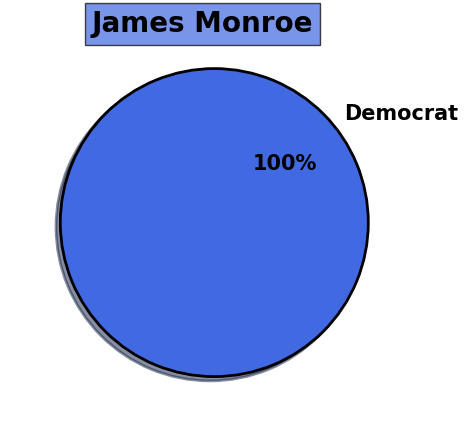

In [104]:
plot_party_distribution(df, vect, nb, 'James Monroe')

<br>

### James Madison : Democratic-Republican Party

In [98]:
df[df['name'] == 'James Madison']['transcript'].apply(predict) # D-R

969      Democrat
970      Democrat
971      Democrat
972      Democrat
973      Democrat
974      Democrat
975      Democrat
976      Democrat
977      Democrat
978      Democrat
979      Democrat
980      Democrat
981      Democrat
982      Democrat
983      Democrat
984      Democrat
985    Republican
986      Democrat
987      Democrat
988      Democrat
989      Democrat
991      Democrat
Name: transcript, dtype: object

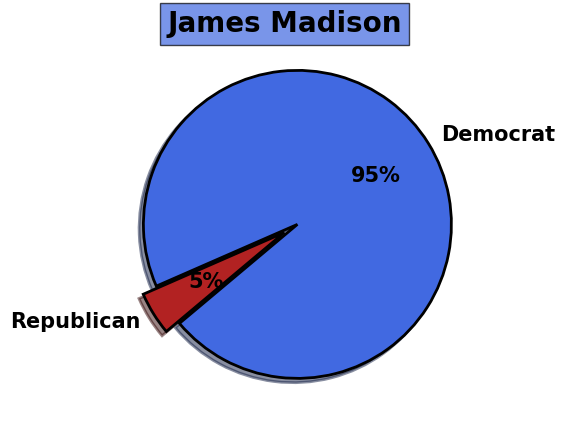

In [105]:
plot_party_distribution(df, vect, nb, 'James Madison')

<br>

### Thomas Jefferson : Democratic Republican Party

In [61]:
df[df['name'] == 'Thomas Jefferson']['transcript'].apply(predict) # D-R

990       Democrat
992       Democrat
993       Democrat
994     Republican
995     Republican
996       Democrat
997       Democrat
998       Democrat
999       Democrat
1000    Republican
1001      Democrat
1002      Democrat
1003      Democrat
1004      Democrat
1005      Democrat
1006      Democrat
1007    Republican
1008    Republican
1009      Democrat
1010    Republican
1011    Republican
1012      Democrat
1013      Democrat
1014      Democrat
Name: transcript, dtype: object

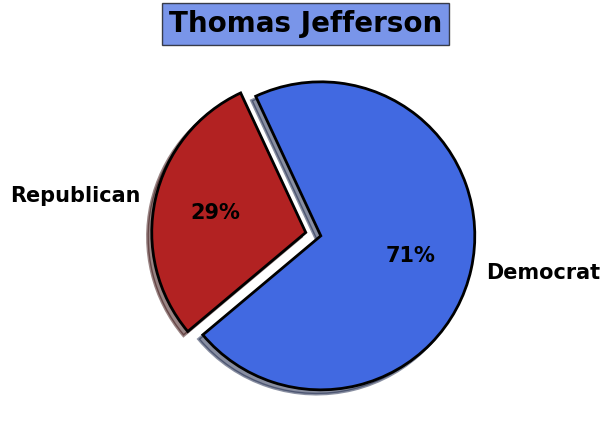

In [106]:
plot_party_distribution(df, vect, nb, 'Thomas Jefferson')

<br>

### John Adams : Federalist Party

In [62]:
df[df['name'] == 'John Adams']['transcript'].apply(predict) # Federalist

1015      Democrat
1016    Republican
1017      Democrat
1018      Democrat
1019      Democrat
1020    Republican
1021      Democrat
1022      Democrat
1023      Democrat
Name: transcript, dtype: object

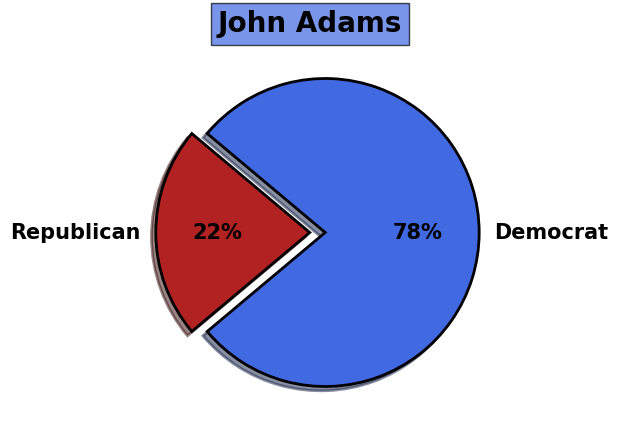

In [112]:
plot_party_distribution(df, vect, nb, 'John Adams')

<br>

### George Washington : Independent 

In [107]:
df[df['name'] == 'George Washington']['transcript'].apply(predict) # None

1024      Democrat
1025      Democrat
1026      Democrat
1027      Democrat
1028      Democrat
1029    Republican
1030      Democrat
1031      Democrat
1032    Republican
1033      Democrat
1034      Democrat
1035      Democrat
1036      Democrat
1037      Democrat
1038    Republican
1039      Democrat
1040      Democrat
1041      Democrat
1042      Democrat
1043      Democrat
1044      Democrat
Name: transcript, dtype: object

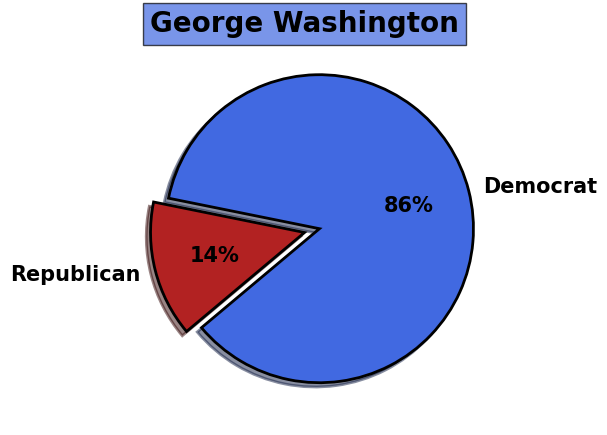

In [108]:
plot_party_distribution(df, vect, nb, 'George Washington')

<br>

# Word Cloud

In [56]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from pandas import Series

def nltk_pos(arg):
    tagged_list = pos_tag(word_tokenize(arg))
    word_tagg = [word[0] for word in tagged_list if word[1] in ['NN','NNP','NNS','NNPS','VBP','VBZ','VB','VBD','VBN','JJ','JJR','JJS','RB','RBR','RBS']]
    return word_tagg

df['token'] = df['transcript'].apply(nltk_pos)

total = df['token']
repu = df[df['party']=='Republican']['token']
demo = df[df['party']=='Democrat']['token']

stopwords = stopwords.words('english')

stopwords.append('has')
stopwords.append('is')
stopwords.append('are')
stopwords.append('not')
stopwords.append('have')
stopwords.append('be')
stopwords.append('were')
stopwords.append('been')
stopwords.append('n\'t')
stopwords.append('mr.')
stopwords.append('\'s')
stopwords.append('\'re')
stopwords.append('\'ve')
stopwords.append('said')
stopwords.append('much')
stopwords.append('president')
stopwords.append('united')
stopwords.append('states')
stopwords.append('also')
stopwords.append('america')
stopwords.append('american')
stopwords.append('years')

total = [j for i in total for j in i if len(j) >= 2 and j not in stopwords]
repu = [j for i in repu for j in i if len(j) >= 2 and j not in stopwords]
demo = [j for i in demo for j in i if len(j) >= 2 and j not in stopwords]

total_freq = Series(total).value_counts()
repu_freq = Series(repu).value_counts()
demo_freq = Series(demo).value_counts()

<br>

## Total 

(-0.5, 999.5, 999.5, -0.5)

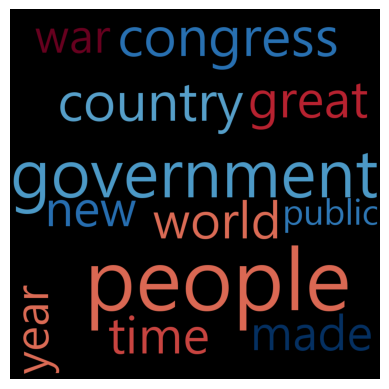

In [57]:
from wordcloud import WordCloud

w = WordCloud(font_path="C:/Window/Fonts/malgun.ttf",
              width=1000,height=1000,
              background_color='black',
              colormap='RdBu',).generate_from_frequencies(total_freq[total_freq >= 5000])
plt.imshow(w)
plt.axis('off')

<br>

## Republican 

(-0.5, 999.5, 999.5, -0.5)

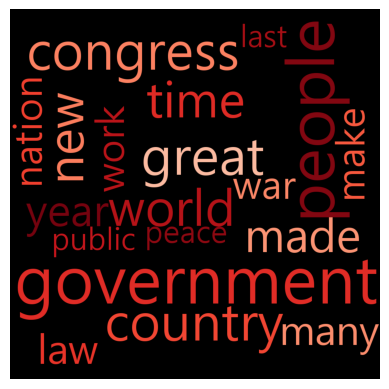

In [58]:
from wordcloud import WordCloud

w = WordCloud(font_path="C:/Window/Fonts/malgun.ttf",
              width=1000,height=1000,
              background_color='black',
              colormap='Reds').generate_from_frequencies(repu_freq[repu_freq >= 2000])
plt.imshow(w)
plt.axis('off')

<br>

## Democrat 

(-0.5, 999.5, 999.5, -0.5)

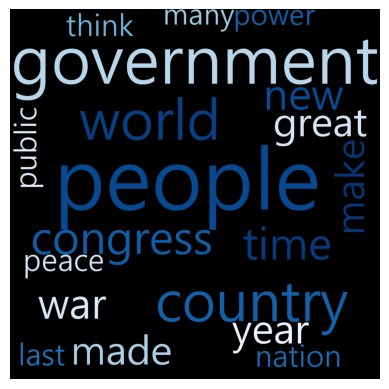

In [59]:
from wordcloud import WordCloud

w = WordCloud(font_path="C:/Window/Fonts/malgun.ttf",
              width=1000,height=1000,
              background_color='black',
              colormap='Blues_r').generate_from_frequencies(demo_freq[demo_freq >= 2000])
plt.imshow(w)
plt.axis('off')

<br>

# Horizontal Bar Graphs

## Democrat vs. Republican

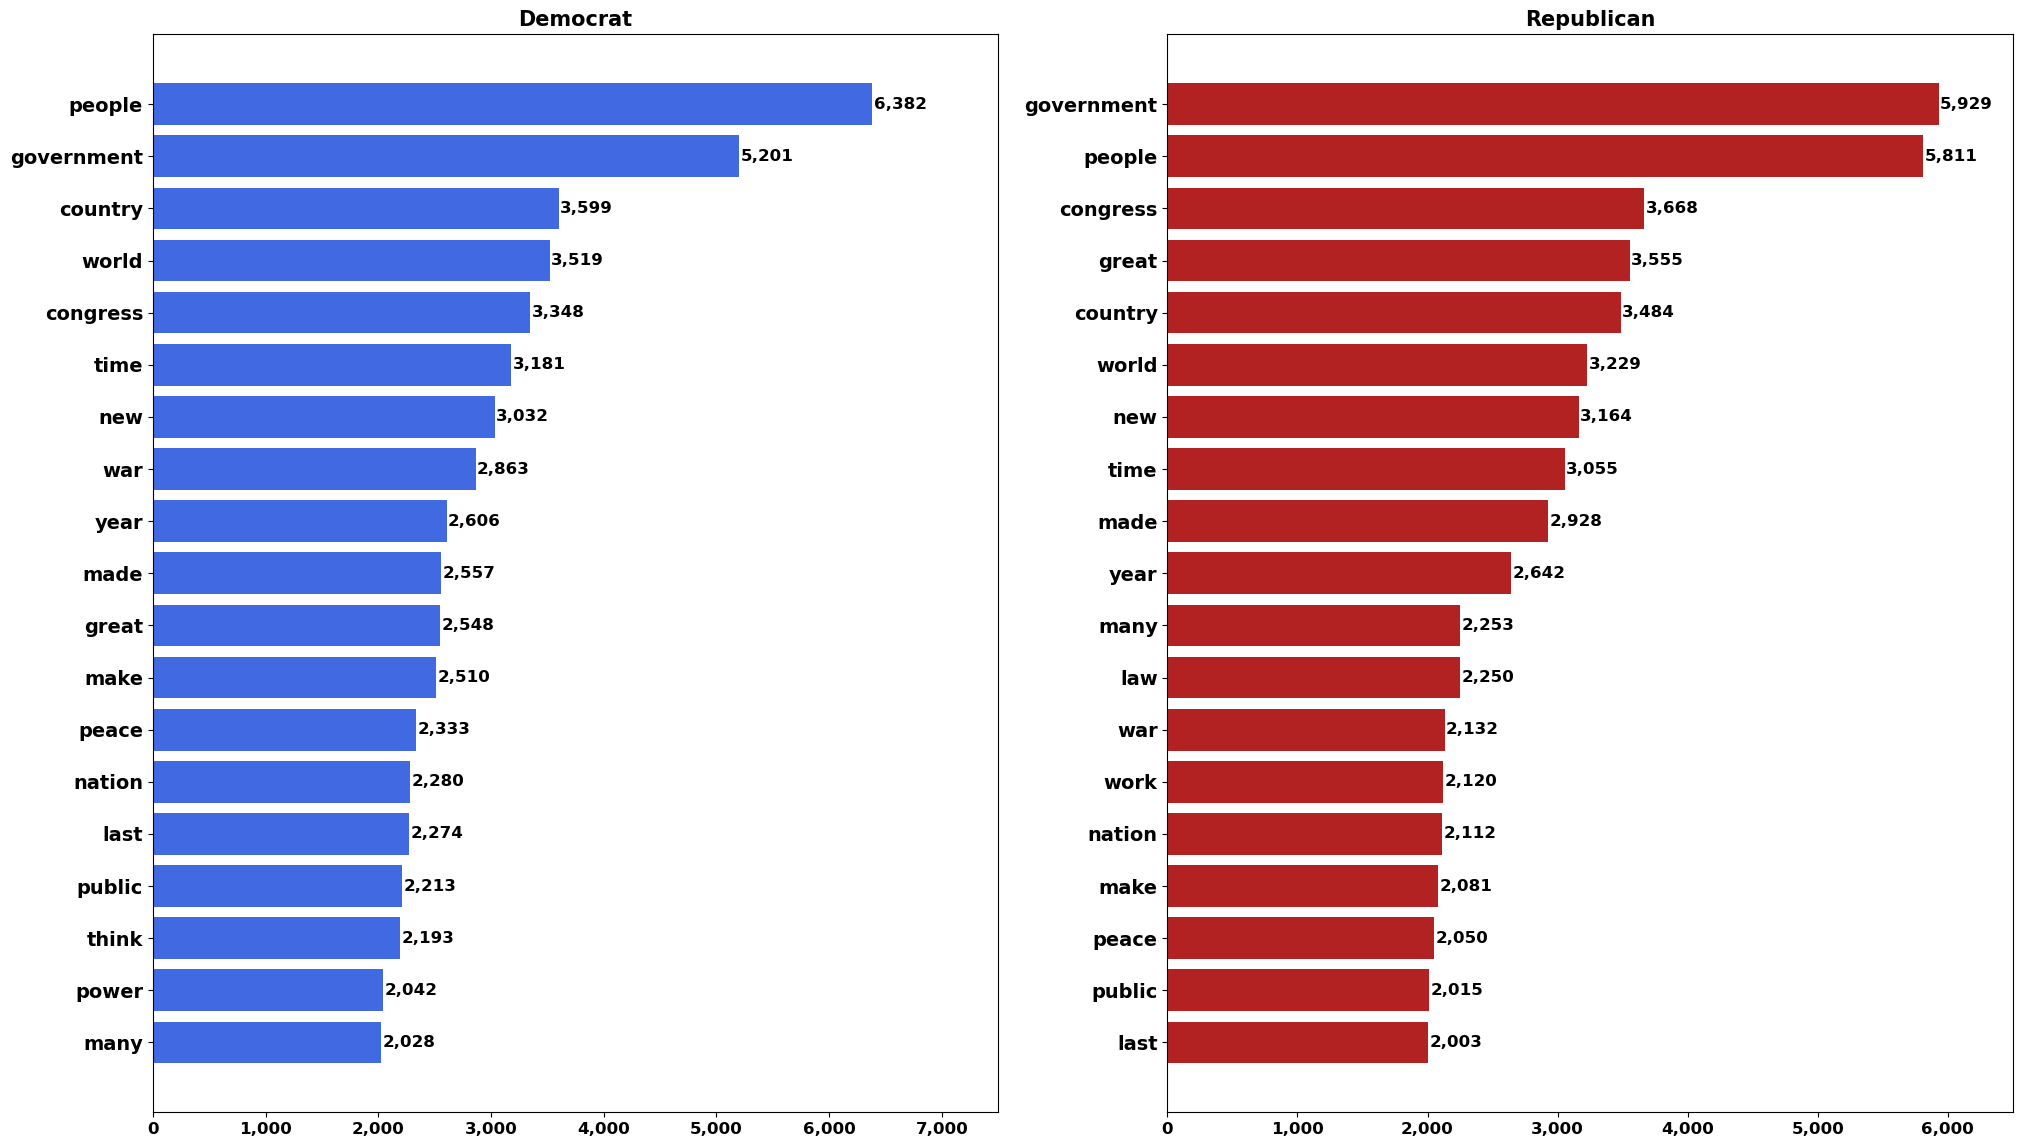

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 14))

# Democrat Plot
p1 = ax[0].barh(demo_freq[demo_freq >= 2000].index, demo_freq[demo_freq >= 2000], color='royalblue')
ax[0].set_title("Democrat", weight='bold', fontsize=15)

# Format and set the bar labels for Democrat plot
bar_values_demo = [int(bar.get_width()) for bar in p1]
formatted_values_demo = [f'{value:,.0f}' for value in bar_values_demo]
ax[0].bar_label(p1, labels=formatted_values_demo, padding=1, label_type='edge', fontsize=12, fontweight='bold', color='black')

ax[0].invert_yaxis()
ax[0].set_xlim(0, 7500)
ax[0].set_xticklabels([f'{int(val):,.0f}' for val in ax[0].get_xticks()], rotation=0, weight='bold', size=12)
ax[0].set_yticklabels(demo_freq[demo_freq >= 2000].index, weight='bold', size=14)

# Republican Plot
p = ax[1].barh(repu_freq[repu_freq >= 2000].index, repu_freq[repu_freq >= 2000], color='firebrick')
ax[1].set_title("Republican", weight='bold', fontsize=15)

# Format and set the bar labels for Republican plot
bar_values_repu = [int(bar.get_width()) for bar in p]
formatted_values_repu = [f'{value:,.0f}' for value in bar_values_repu]
ax[1].bar_label(p, labels=formatted_values_repu, padding=1, label_type='edge', fontsize=12, fontweight='bold', color='black')

ax[1].invert_yaxis()
ax[1].set_xlim(0, 6500)
ax[1].set_xticklabels([f'{int(val):,.0f}' for val in ax[1].get_xticks()], rotation=0, weight='bold', size=12)
ax[1].set_yticklabels(repu_freq[repu_freq >= 2000].index, weight='bold', size=14)

plt.show()

<br>

## Total

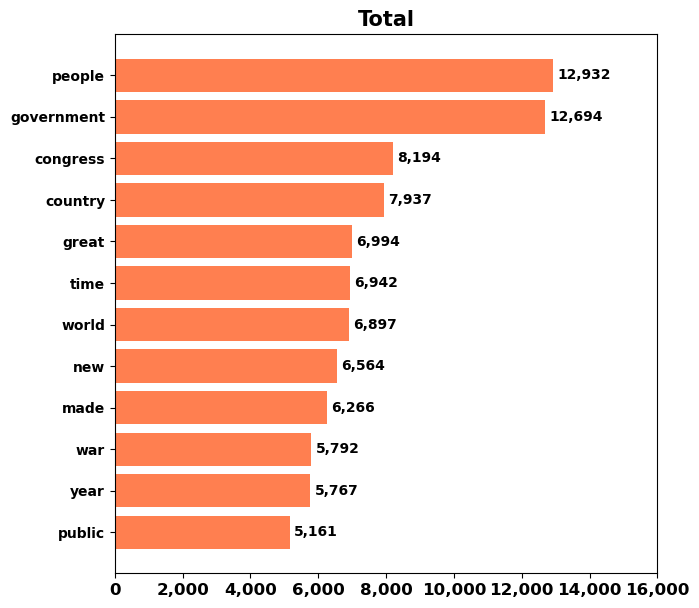

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Extract bar heights (values) and format them.
bar_values = [int(bar.get_width()) for bar in p]
formatted_values = [f'{value:,.0f}' for value in bar_values]

fig, ax = plt.subplots(figsize=(7,7)) 
p = ax.barh(total_freq[total_freq >= 5000].index,total_freq[total_freq >= 5000],color='coral',align='center')
ax.set_title("Total",weight='bold',fontsize=15)
ax.bar_label(p, labels=formatted_values, padding=3, label_type='edge', fontsize=10, fontweight='bold', color='black')
ax.set_xlim(0, 14500)
ax.invert_yaxis()
ax.set_xticks(ax.get_xticks())  # this line is actually redundant but added for clarity
ax.set_xticklabels([f'{int(val):,.0f}' for val in ax.get_xticks()], rotation=0, weight='bold', size=12)
ax.set_yticklabels(total_freq[total_freq >= 5000].index,weight='bold')
plt.show()

<br>

# Political Party : # of speech pie chart

In [63]:
df['party'].fillna('NaN (George Washington)').value_counts()

Democrat                   467
Republican                 423
Democratic-Republican       64
National Union              31
Whig                        30
NaN (George Washington)     21
Federalist                   9
Name: party, dtype: int64

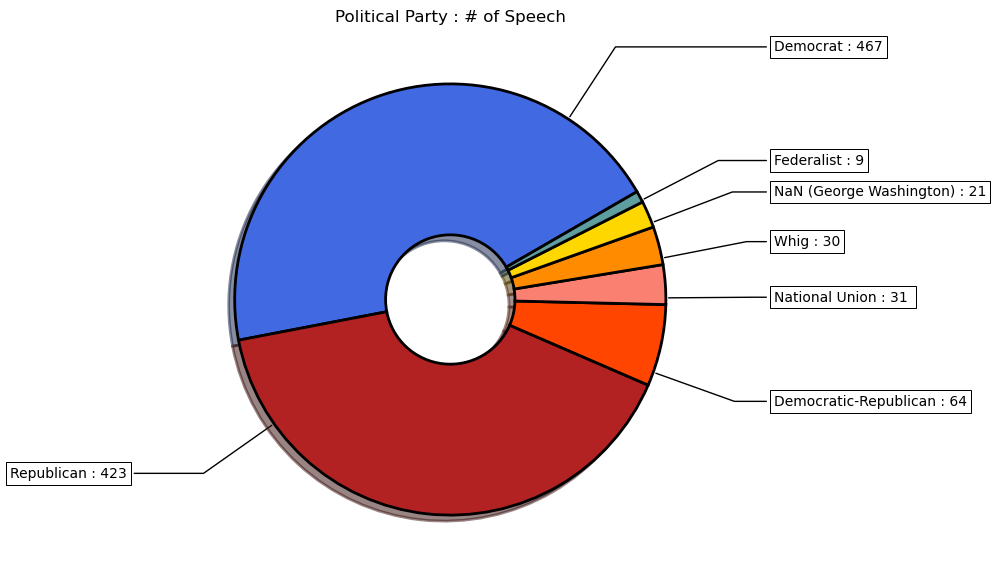

In [30]:
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))

recipe = ["Democrat : 467",
          "Republican : 423",
          "Democratic-Republican : 64",
          "National Union : 31 ",
          "Whig : 30",
          "NaN (George Washington) : 21",
          "Federalist : 9"]
          
data = [i for i in df['party'].value_counts(dropna=False)]

wedges, texts = ax.pie(data, wedgeprops={'width':0.7, "linewidth" :2, "edgecolor":'black'}, 
                       startangle=30,
                       colors=['royalblue','firebrick','orangered','salmon','darkorange','gold','cadetblue'],
                       shadow=True,
                       textprops={'fontsize':14, 'color':'black'},
                       explode=(0.00,0.00,0,0,0,0,0))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/6. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.5*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Political Party : # of Speech")

plt.show()

<br>

# Graph of U.S. President's political Party Affilliation

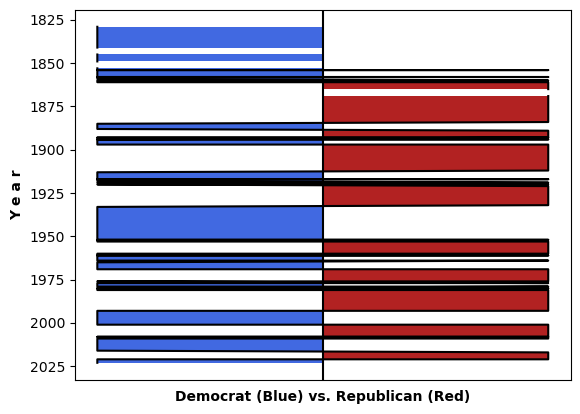

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# change the 'date' column into date format
df['date'] = pd.to_datetime(df['date'],format='%B %d, %Y')
df['year'] = df['date'].apply(lambda x : x.year)
df['number'] = None
df.loc[df['party'] == 'Democrat','number'] = -1
df.loc[df['party'] == 'Republican','number'] = 1

s = df['year']
t = df['number']

fig, ax = plt.subplots()

ax.plot(t, s, color='black')
ax.axvline(0, color='black')

ax.fill_betweenx(s, 1, where=t > 0, facecolor='firebrick', alpha=1)
ax.fill_betweenx(s, -1, where=t < 0, facecolor='royalblue', alpha=1)
# ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel("Democrat (Blue) vs. Republican (Red)",fontdict={'fontweight': 'bold'})
plt.ylabel("Y e a r",fontdict={'fontweight': 'bold'})
ax.axes.get_xaxis().set_ticks([])
 
plt.show()